### Import

In [1]:
import os
os.chdir('..')
print(os.getcwd())

from Src.config import configuration
cfg = configuration.config_manager().get_path()

print(cfg)

c:\Users\yanni\Documents\Projects\Pred_maint_projects
[2024-01-31 18:26:09,990: INFO: common: yaml file: Config\path.yaml loaded successfully]
[2024-01-31 18:26:09,990: INFO: common: created directory at: workdir]
[2024-01-31 18:26:09,990: INFO: common: created directory at: workdir/model]
{'config_path': {'work_dir': 'workdir', 'model_dir': 'workdir/model', 'local_data_file': 'data/predictive_maintenance.csv', 'local_data_file_analyse': 'workdir/predictive_maintenance_A.csv', 'local_data_file_validation': 'workdir/predictive_maintenance_validation.csv', 'local_data_file_train': 'workdir/predictive_maintenance_train.csv', 'local_data_file_test': 'workdir/predictive_maintenance_test.csv'}}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2, l1
from keras.metrics import Accuracy, SparseCategoricalAccuracy, CategoricalAccuracy, AUC, \
    PrecisionAtRecall, Recall, Precision, F1Score

from Src.Model_maintenance import modelMaintenance

[2024-01-22 22:40:01,862: WARNING: module_wrapper: From c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.
]


### Load data

Load dataframe

In [3]:
#df_train = pd.read_csv('..\data\predictive_maintenance_train_resampled.csv')
df_train = pd.read_csv(cfg.config_path.local_data_file_train)
#df_test = pd.read_csv('..\data\predictive_maintenance_test_resampled.csv')
df_test = pd.read_csv(cfg.config_path.local_data_file_test)
#df_val = pd.read_csv('..\data\predictive_maintenance_validation.csv')
df_val = pd.read_csv(cfg.config_path.local_data_file_validation)


Extract the name of variable of 'Target'

In [4]:
name_target_col = list(filter(lambda ligne: 'Failure' in ligne, df_train.columns))
name_target_col

['Heat Dissipation Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Tool Wear Failure']

Split to train and test data
Separation of explanatory variables and variables to identify

In [5]:
X_train = df_train.drop(columns=name_target_col)
y_train = df_train[name_target_col]
X_test = df_test.drop(columns=name_target_col)
y_test = df_test[name_target_col]
X_val = df_val.drop(columns=name_target_col)
y_val = df_val[name_target_col]

In [6]:
num_features = X_train.shape[1] # Nombre de variables explicatives
num_target = y_train.shape[1]   # Nombre de variables cibles

In [7]:

keras.backend.clear_session()


[2024-01-22 22:40:10,843: WARNING: module_wrapper: From c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\backend.py:277: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.
]


### Create model

In [8]:

model = modelMaintenance(
    num_layers=5, 
    num_input=num_features, 
    num_output=num_target,
    loss=CategoricalCrossentropy(),
    optimizer='adam',#Adam(5e-4),
    metrics=[CategoricalAccuracy(), AUC(),  Precision(), Recall()],
    path_model=cfg.config_path.model_dir)

[2024-01-22 22:40:13,664: WARNING: module_wrapper: From c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.
]


c:\Users\yanni\OneDrive\Documents\GitHub\Predictive_maintenance\Predictive_maintenance
workdir/model/model.png


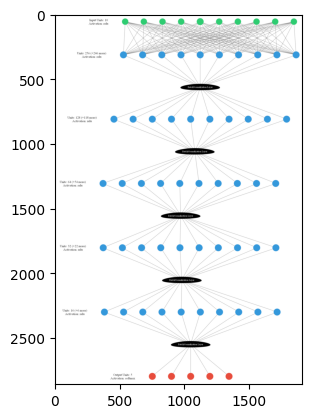

In [9]:
model.plot_model()

### Training Model

In [9]:
model.train(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), batch_size=256, epochs=100, verbose=1)

Epoch 1/100
[2024-01-22 22:40:18,059: WARNING: module_wrapper: From c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.
]
25/25 [==============================] - 3s 127ms/step - loss: 1.2833 - categorical_accuracy: 0.3734 - auc: 0.6019 - precision: 0.4141 - recall: 0.2230 - val_loss: 1.3970 - val_categorical_accuracy: 0.8039 - val_auc: 0.9210 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 3s 110ms/step - loss: 0.6454 - categorical_accuracy: 0.4104 - auc: 0.6321 - precision: 0.4291 - recall: 0.2609 - val_loss: 1.0990 - val_categorical_accuracy: 0.9091 - val_auc: 0.9907 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 3s 120ms/step - loss: 0.5101 - categorical_accuracy: 0.4427 - a

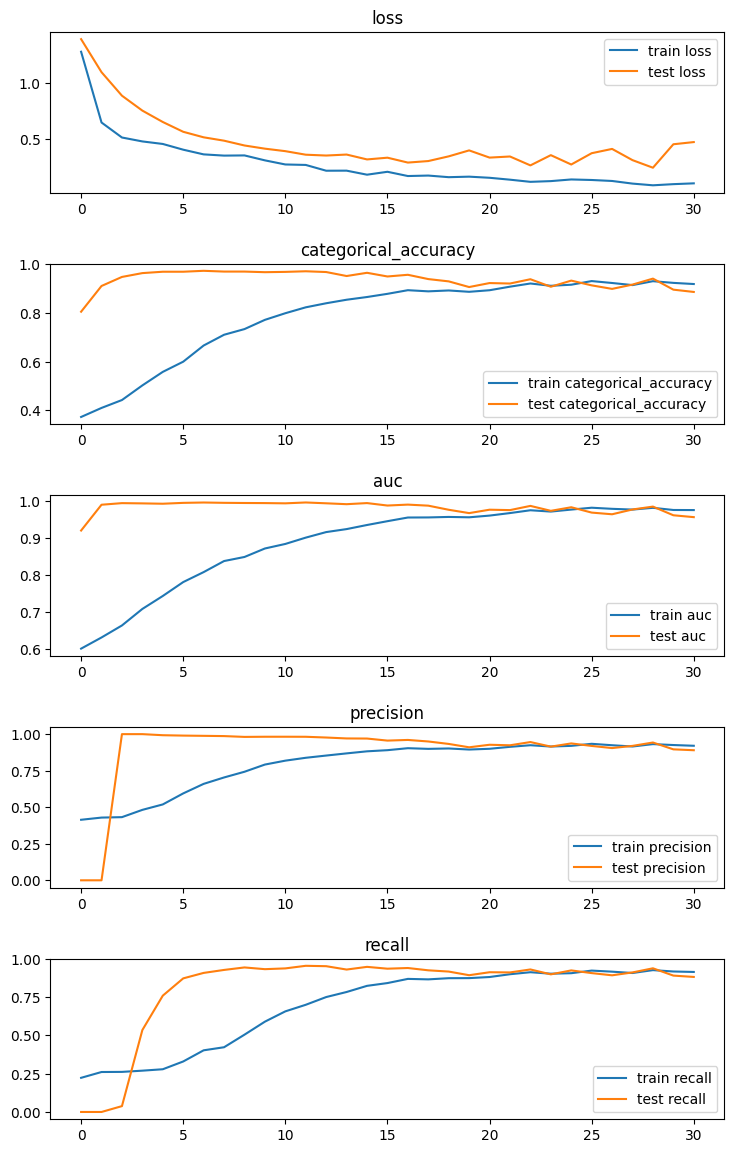

In [10]:
model.plot_history()

63/63 [==============================] - 1s 9ms/step
Confusion matrix, without normalization
[[  21    1    0    0    0]
 [  28 1771   44   21   65]
 [   0    0   16    0    0]
 [   0    1    2   16    0]
 [   0    3    1    0    5]]


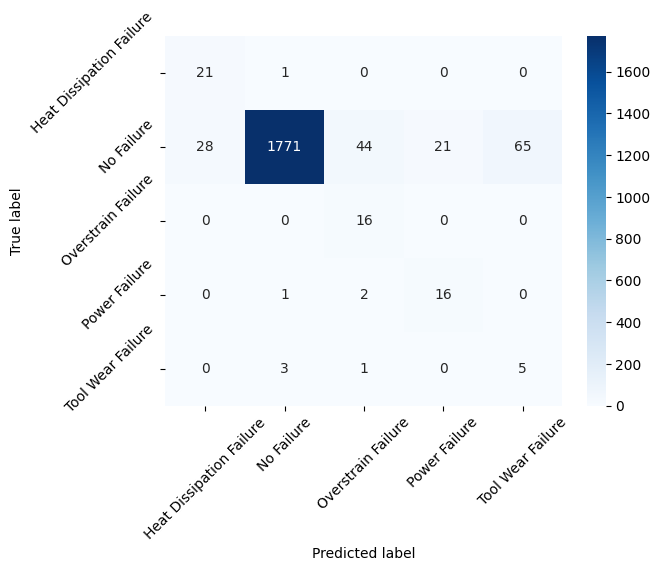

In [11]:
y_pred_val = model.predict(X_val.to_numpy())
model.plot_confusion_matrix(y_val.to_numpy().argmax(axis=1), y_pred_val.argmax(axis=1), name_target_col)

In [12]:
res, score_details = model.print_evaluation(X_val.to_numpy(), y_val.to_numpy(), y_pred_val>0.5, verbose=0)


63/63 - 2s - loss: 0.3430 - categorical_accuracy: 0.9168 - auc: 0.9728 - precision: 0.9224 - recall: 0.9118 - 2s/epoch - 29ms/step


In [13]:

df_score = pd.DataFrame()
df_score = pd.concat([df_score, pd.DataFrame(score_details, index=[0])], axis=0)
df_score

,loss,categorical_accuracy,auc,precision,recall,kappa,F1_score
0,0.34298,0.916792,0.972801,0.922414,0.911779,0.896482,0.967018


### Training multiple model

In [ ]:
score = {}
df_score = pd.DataFrame()

for i in range(7,10,1):

    keras.backend.clear_session()
    
    model = modelMaintenance(
        num_layers=i, 
        num_input=num_features, 
        num_output=num_target,
        loss=CategoricalCrossentropy(),
        optimizer='adam',#Adam(5e-4),
        metrics=[CategoricalAccuracy(), AUC(),  Precision(), Recall()])
    
    model.train(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), batch_size=256, epochs=100, verbose=0)

    y_pred_val = model.predict(X_val.to_numpy())

    print('Nombre de couches : ', i)
    score[i], score_details = model.print_evaluation(X_val.to_numpy(), y_val.to_numpy(), y_pred_val>0.5, verbose=0)
    
    df_score = pd.concat([df_score, pd.DataFrame(score_details, index=[i])], axis=0)
    print('')

    

In [ ]:
df_score.columns.drop('loss')

In [ ]:
#df_score.style.background_gradient(cmap='viridis')
df_score.style.highlight_max(color = 'blue', subset=df_score.columns.drop('loss')).highlight_min(color = 'green', subset=['loss'])
#df_score.style.highlight_min(color = 'blue', subset=['loss'])
#display(df_score)